# Environment

In [37]:
!git clone https://github.com/cuongtv312/marl-delivery.git marl_delivery

fatal: destination path 'marl_delivery' already exists and is not an empty directory.


In [38]:
try:
    from env import Environment
except:
    from marl_delivery.env import Environment
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import random
import os
from sklearn.calibration import LabelEncoder



SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
device

device(type='cuda')

In [39]:
def convert_state(state, persistent_packages, current_robot_idx):
    """
    Convert state to a 2D multi-channel tensor for a specific robot.
    - 6 channels for robot-specific observation:
        0. Map
        1. Urgency of 'waiting' packages (if robot is not carrying)
        2. Start positions of 'waiting' packages (if robot is not carrying)
        3. Other robots' positions
        4. Current robot's position
        5. Current robot's carried package target (if robot is carrying)

    Args:
        state (dict): Raw state from the environment.
                      Expected keys: "map", "robots", "time_step".
                      state["robots"] is a list of tuples: (pos_x+1, pos_y+1, carrying_package_id)
        persistent_packages (dict): Dictionary tracking all active packages.
                                    Positions are 0-indexed.
        current_robot_idx (int): Index of the current robot for which to generate the observation.

    Returns:
        np.ndarray of shape (6, n_rows, n_cols)
    """
    grid = np.array(state["map"])
    n_rows, n_cols = grid.shape
    n_channels = 6
    tensor = np.zeros((n_channels, n_rows, n_cols), dtype=np.float32)

    # --- Channel 0: Map ---
    tensor[0] = grid

    current_time_step = state["time_step"]
    if isinstance(current_time_step, np.ndarray): # Handle case where time_step might be an array
        current_time_step = current_time_step[0]

    # Get current robot's data and determine if it's carrying a package
    # Ensure current_robot_idx is valid
    if current_robot_idx < 0 or current_robot_idx >= len(state["robots"]):
        # This case should ideally be handled by the caller or indicate an error
        # print(f"Warning: Invalid current_robot_idx {current_robot_idx}")
        return tensor # Return empty tensor or handle error appropriately

    current_robot_data = state["robots"][current_robot_idx]
    carried_pkg_id_by_current_robot = current_robot_data[2] # 1-indexed ID, 0 if not carrying

    # --- Channel 1: Urgency of 'waiting' packages (if robot is not carrying) ---
    # --- Channel 2: Start positions of 'waiting' packages (if robot is not carrying) ---
    if carried_pkg_id_by_current_robot == 0: # Robot is NOT carrying a package
        for pkg_id, pkg_data in persistent_packages.items():
            if pkg_data['status'] == 'waiting':
                sr, sc = pkg_data['start_pos']  # 0-indexed
                st = pkg_data['start_time']
                dl = pkg_data['deadline']

                # Check if package is active (start_time has passed)
                if current_time_step >= st:
                    # Channel 1: Urgency
                    urgency = 0
                    if dl > st: # Avoid division by zero or negative duration
                        # Normalize urgency: 0 (just appeared) to 1 (deadline reached)
                        # Cap at 1 if current_time_step exceeds deadline
                        urgency = min(1.0, max(0.0, (current_time_step - st) / (dl - st)))
                    elif dl == st: # Deadline is the start time
                         urgency = 1.0 if current_time_step >= st else 0.0
                    # else: dl < st, invalid, urgency remains 0

                    if 0 <= sr < n_rows and 0 <= sc < n_cols: # Boundary check
                        tensor[1, sr, sc] = max(tensor[1, sr, sc], urgency) # Use max if multiple pkgs at same spot

                    # Channel 2: Start position
                    if 0 <= sr < n_rows and 0 <= sc < n_cols: # Boundary check
                        tensor[2, sr, sc] = 1.0 # Mark presence
    # If robot is carrying, channels 1 and 2 remain all zeros.

    # --- Channel 3: Other robots' positions ---
    for i, rob_data in enumerate(state["robots"]):
        if i == current_robot_idx:
            continue # Skip the current robot
        rr, rc, _ = rob_data # Positions are 1-indexed from env
        rr_idx, rc_idx = int(rr) - 1, int(rc) - 1 # Convert to 0-indexed
        if 0 <= rr_idx < n_rows and 0 <= rc_idx < n_cols: # Boundary check
            tensor[3, rr_idx, rc_idx] = 1.0

    # --- Channel 4: Current robot's position ---
    # current_robot_data was fetched earlier
    crr, crc, _ = current_robot_data # Positions are 1-indexed
    crr_idx, crc_idx = int(crr) - 1, int(crc) - 1 # Convert to 0-indexed
    if 0 <= crr_idx < n_rows and 0 <= crc_idx < n_cols: # Boundary check
        tensor[4, crr_idx, crc_idx] = 1.0

    # --- Channel 5: Current robot's carried package target (if robot is carrying) ---
    if carried_pkg_id_by_current_robot != 0:
        # Ensure the package ID from state['robots'] is valid and exists in persistent_packages
        if carried_pkg_id_by_current_robot in persistent_packages:
            pkg_data_carried = persistent_packages[carried_pkg_id_by_current_robot]
            # Double check status, though if robot carries it, it should be 'in_transit'
            # or just became 'in_transit' in the persistent_packages update logic.
            # For this observation, we primarily care about its target.
            tr_carried, tc_carried = pkg_data_carried['target_pos'] # 0-indexed
            if 0 <= tr_carried < n_rows and 0 <= tc_carried < n_cols: # Boundary check
                tensor[5, tr_carried, tc_carried] = 1.0
        # else:
            # This case might indicate an inconsistency.
            # print(f"Warning: Robot {current_robot_idx} carrying pkg {carried_pkg_id_by_current_robot} not in persistent_packages.")
    # If robot is not carrying, channel 5 remains all zeros.

    return tensor

# Agent Network

In [40]:
class AgentNetwork(nn.Module):
    def __init__(self, observation_shape, action_dim):
        super(AgentNetwork, self).__init__()
        # observation_shape is (C, H, W)
        self.conv1 = nn.Conv2d(observation_shape[0], 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        flat_size = 32 * observation_shape[1] * observation_shape[2]  # 32 * H * W

        self.fc1 = nn.Linear(flat_size, 128)
        self.fc2 = nn.Linear(128, action_dim)

    def forward(self, obs):
        # obs: (N, C, H, W) or (C, H, W)
        if obs.dim() == 3:
            obs = obs.unsqueeze(0)  # (1, C, H, W)
        x = F.relu(self.bn1(self.conv1(obs)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.flatten(start_dim=1)  # (N, 32*H*W)
        x = F.relu(self.fc1(x))
        q_values = self.fc2(x)
        return q_values

# Hyperparameters

In [41]:
ACTION_DIM = 15
NUM_AGENTS = 10
MAP_FILE = "map1.txt"
N_PACKAGES = 100
MOVE_COST = -0.01
DELIVERY_REWARD = 10
DELAY_REWARD = 1
MAX_TIME_STEPS = 100
NUM_EPISODES = 100
BATCH_SIZE = 64
GAMMA = 0.99
LR = 1e-4
WEIGHT_DECAY = 1e-3
MAX_REPLAY_BUFFER_SIZE = 10000
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 100
TAU = 0.01
GRADIENT_CLIPPING = 10
NUM_ENVS = 1

# Replay Buffer

In [42]:
class ReplayBuffer:
    def __init__(self, capacity, obs_shape, device="cpu"):
        self.capacity = capacity
        self.obs_shape = obs_shape
        self.device = device

        _obs_s = (obs_shape,) if isinstance(obs_shape, int) else obs_shape

        self.observations = np.zeros((capacity, *_obs_s), dtype=np.float32)
        self.actions = np.zeros((capacity,), dtype=np.int64)
        self.rewards = np.zeros((capacity,), dtype=np.float32)
        self.next_observations = np.zeros((capacity, *_obs_s), dtype=np.float32)
        self.dones = np.zeros((capacity,), dtype=np.bool_)

        self.ptr = 0
        self.size = 0

    def add(self, obs, action, reward, next_obs, done):
        """
        Adds a transition to the buffer.
        - obs: np.array with shape self.obs_shape
        - action: int
        - reward: float
        - next_obs: np.array with shape self.obs_shape
        - done: bool
        """
        self.observations[self.ptr] = obs
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_observations[self.ptr] = next_obs
        self.dones[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        if self.size == 0:
            print("Warning: Buffer is empty. Returning empty tensors.")
            _obs_s_runtime = (self.obs_shape,) if isinstance(self.obs_shape, int) else self.obs_shape
            empty_obs = torch.empty((0, *_obs_s_runtime), dtype=torch.float32, device=self.device)
            empty_actions = torch.empty((0,), dtype=torch.long, device=self.device)
            empty_rewards = torch.empty((0,), dtype=torch.float32, device=self.device)
            empty_next_obs = torch.empty((0, *_obs_s_runtime), dtype=torch.float32, device=self.device)
            empty_dones = torch.empty((0,), dtype=torch.float32, device=self.device)
            return (empty_obs, empty_actions, empty_rewards, empty_next_obs, empty_dones)

        if self.size < batch_size:
            print(f"Warning: Buffer size ({self.size}) is less than batch size ({batch_size}). Sampling all available data.")
            indices = np.arange(self.size)
        else:
            indices = np.random.choice(self.size, batch_size, replace=False)

        batch_obs = torch.tensor(self.observations[indices], dtype=torch.float32).to(self.device)
        batch_actions = torch.tensor(self.actions[indices], dtype=torch.long).to(self.device)
        batch_rewards = torch.tensor(self.rewards[indices], dtype=torch.float32).to(self.device)
        batch_next_obs = torch.tensor(self.next_observations[indices], dtype=torch.float32).to(self.device)
        batch_dones = torch.tensor(self.dones[indices], dtype=torch.float32).to(self.device)

        return (batch_obs, batch_actions, batch_rewards, batch_next_obs, batch_dones)

    def can_sample(self, batch_size):
        return self.size >= batch_size

    def __len__(self):
        return self.size

# Epsilon-greedy policy


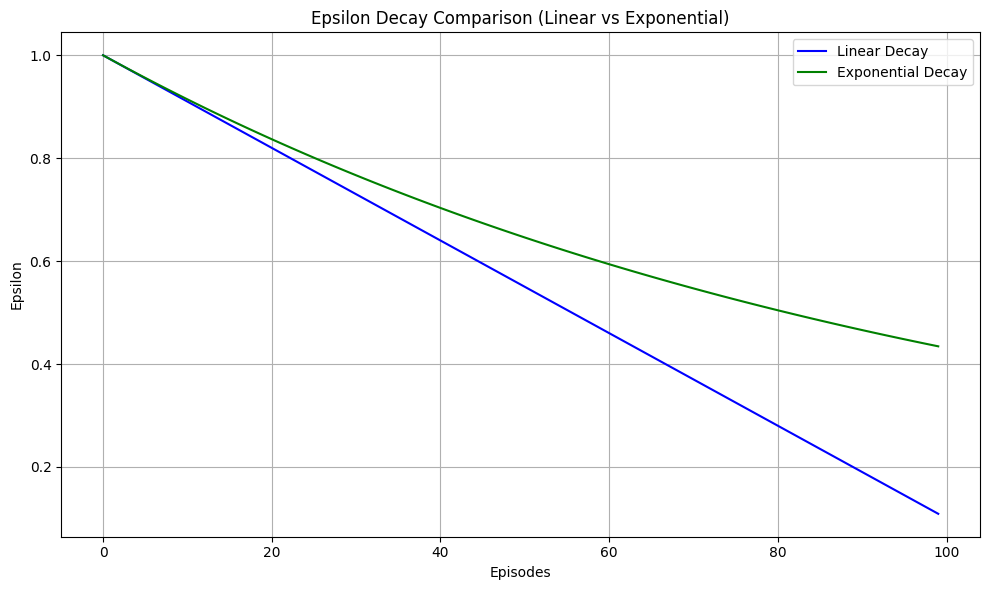

In [43]:
import matplotlib.pyplot as plt

# Define the linear epsilon function
def linear_epsilon(steps_done):
    return max(EPS_END, EPS_START - (EPS_START - EPS_END) * (steps_done / EPS_DECAY))

# Define the corrected exponential epsilon functio.")
def exponential_epsilon(steps_done):
    return EPS_END + (EPS_START - EPS_END) * np.exp(-steps_done / EPS_DECAY)

# Recalculate epsilon values using the defined functions
steps_done = np.arange(NUM_EPISODES)

linear_epsilons = [linear_epsilon(step) for step in steps_done]
exp_epsilons = [exponential_epsilon(step) for step in steps_done]

# Plotting both linear and exponential decay
plt.figure(figsize=(10, 6))
plt.plot(steps_done, linear_epsilons, label='Linear Decay', color='blue')
plt.plot(steps_done, exp_epsilons, label='Exponential Decay', color='green')
plt.title('Epsilon Decay Comparison (Linear vs Exponential)')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [44]:
def save_model(policy_net, path="models/dqn_agent.pt"):
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    torch.save(policy_net.state_dict(), path)

# Reward Shaping

In [46]:
def reward_shaping(
    prev_env_state,
    current_env_state,
    actions_taken,
    persistent_packages_before_action,
    num_agents
):
    """
    Compute shaped rewards for each agent using both base and A*-potential-based shaping.
    """
    # --- Constants ---
    SHAPING_SUCCESSFUL_PICKUP_BONUS = 10
    SHAPING_SUCCESSFUL_DELIVERY_BONUS = 100
    SHAPING_LATE_DELIVERY_PENALTY = -50
    SHAPING_WASTED_PICKUP_PENALTY = -0.01
    SHAPING_WASTED_DROP_PENALTY = 0
    SHAPING_STAY_PENALTY = -0.01
    MOVE_COST = -0.01


    individual_rewards = [MOVE_COST] * num_agents

    current_time_from_env = current_env_state['time_step']
    if isinstance(current_time_from_env, np.ndarray):
        current_time_from_env = current_time_from_env[0]

    time_at_prev_state = prev_env_state.get('time_step', current_time_from_env - 1)
    if isinstance(time_at_prev_state, np.ndarray):
        time_at_prev_state = time_at_prev_state[0]

    map_grid = np.array(current_env_state["map"])

    for i in range(num_agents):
        agent_action = actions_taken[i]
        package_op = int(agent_action[1])  # 0: None, 1: Pick, 2: Drop

        prev_robot_info = prev_env_state['robots'][i]
        current_robot_info = current_env_state['robots'][i]

        robot_prev_pos_0idx = (prev_robot_info[0] - 1, prev_robot_info[1] - 1)
        robot_current_pos_0idx = (current_robot_info[0] - 1, current_robot_info[1] - 1)

        # Penalty for staying in place if there are waiting packages
        waiting_packages_exist = any(
            pkg['status'] == 'waiting' and pkg['start_time'] <= time_at_prev_state
            for pkg in persistent_packages_before_action.values()
        )
        if robot_prev_pos_0idx == robot_current_pos_0idx and waiting_packages_exist:
            individual_rewards[i] += SHAPING_STAY_PENALTY
        elif robot_prev_pos_0idx == robot_current_pos_0idx and not waiting_packages_exist:
            individual_rewards[i] -= MOVE_COST  # cancel out move cost if no work to do

        if i >= len(prev_env_state['robots']) or i >= len(current_env_state['robots']):
            continue

        prev_carrying_id = prev_robot_info[2]
        current_carrying_id = current_robot_info[2]


        # --- Base Reward Shaping ---
        # 1. Shaping for PICKUP attempts
        if package_op == 1:
            if prev_carrying_id == 0 and current_carrying_id != 0:
                # Successfully picked up a package
                individual_rewards[i] += SHAPING_SUCCESSFUL_PICKUP_BONUS
            elif prev_carrying_id != 0:
                # Tried to pick up while already carrying
                individual_rewards[i] += SHAPING_WASTED_PICKUP_PENALTY
            elif prev_carrying_id == 0 and current_carrying_id == 0:
                # Attempted pickup but failed (still not carrying).
                package_was_available_and_waiting = False
                for pkg_id, pkg_data in persistent_packages_before_action.items():
                    if pkg_data['status'] == 'waiting' and \
                       pkg_data['start_pos'] == robot_prev_pos_0idx and \
                       pkg_data['start_time'] <= time_at_prev_state:
                        package_was_available_and_waiting = True
                        break
                if not package_was_available_and_waiting:
                    individual_rewards[i] += SHAPING_WASTED_PICKUP_PENALTY

        # 2. Shaping for DROP attempts
        elif package_op == 2:
            if prev_carrying_id != 0 and current_carrying_id == 0:
                dropped_pkg_id = prev_carrying_id
                if dropped_pkg_id in persistent_packages_before_action:
                    pkg_info = persistent_packages_before_action[dropped_pkg_id]
                    pkg_target_pos_0idx = pkg_info['target_pos']
                    pkg_deadline = pkg_info['deadline']
                    if robot_current_pos_0idx == pkg_target_pos_0idx:
                        individual_rewards[i] += SHAPING_SUCCESSFUL_DELIVERY_BONUS
                        if current_time_from_env > pkg_deadline:
                            individual_rewards[i] += SHAPING_LATE_DELIVERY_PENALTY
                # else: dropped a package not in persistent_packages_before_action (should not happen)
            elif prev_carrying_id == 0:
                # Tried to drop when not carrying anything
                individual_rewards[i] += SHAPING_WASTED_DROP_PENALTY

    return individual_rewards


# Initialize

In [47]:
class VectorizedEnv:
    def __init__(self, env_cls, num_envs, **env_kwargs):
        # Assign a unique seed to each environment if 'seed' is in env_kwargs
        base_seed = env_kwargs.get('seed', None)
        self.envs = []
        for idx in range(num_envs):
            env_args = env_kwargs.copy()
            if base_seed is not None:
                env_args['seed'] = base_seed + idx
            self.envs.append(env_cls(**env_args))
        self.num_envs = num_envs

    def reset(self):
        return [env.reset() for env in self.envs]

    def step(self, actions):
        # actions: list of actions for each env
        results = [env.step(action) for env, action in zip(self.envs, actions)]
        next_states, rewards, dones, infos = zip(*results)
        return list(next_states), list(rewards), list(dones), list(infos)

    def render(self):
        for env in self.envs:
            env.render_pygame() 

In [48]:
try:
    vec_env = VectorizedEnv(
        Environment, num_envs=NUM_ENVS,
        map_file=MAP_FILE,
        n_robots=NUM_AGENTS,
        n_packages=N_PACKAGES,
        move_cost=MOVE_COST,
        delivery_reward=DELIVERY_REWARD,
        delay_reward=DELAY_REWARD,
        max_time_steps=MAX_TIME_STEPS
    )
except:
    vec_env = VectorizedEnv(
        Environment, num_envs=NUM_ENVS,
        map_file=f'marl_delivery/{MAP_FILE}',
        n_robots=NUM_AGENTS,
        n_packages=N_PACKAGES,
        move_cost=MOVE_COST,
        delivery_reward=DELIVERY_REWARD,
        delay_reward=DELAY_REWARD,
        max_time_steps=MAX_TIME_STEPS
    )

In [49]:
import copy

class DQNTrainer:
    def __init__(self, env, lr=LR, weight_decay=WEIGHT_DECAY, gamma=GAMMA, tau=TAU, gradient_clipping=GRADIENT_CLIPPING, num_envs=1):
        self.env = env
        self.num_envs = num_envs
        OBS_DIM = (6, env.envs[0].n_rows, env.envs[0].n_cols) if hasattr(env, 'envs') else (6, env.n_rows, env.n_cols)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Initialize LabelEncoders for actions
        self.le_move = LabelEncoder()
        self.le_move.fit(['S', 'L', 'R', 'U', 'D']) # Stay, Left, Right, Up, Down
        self.le_pkg_op = LabelEncoder()
        self.le_pkg_op.fit(['0', '1', '2']) # 0: None, 1: Pickup, 2: Drop
        self.NUM_MOVE_ACTIONS = len(self.le_move.classes_) # 5
        self.NUM_PKG_OPS = len(self.le_pkg_op.classes_) # 3
        
        # Network
        self.agent_network = AgentNetwork(OBS_DIM, ACTION_DIM).to(self.device)
        
        # Target networks
        self.target_agent_network = AgentNetwork(OBS_DIM, ACTION_DIM).to(self.device)
        self.target_agent_network.load_state_dict(self.agent_network.state_dict())
        
        self.buffer = ReplayBuffer(capacity=MAX_REPLAY_BUFFER_SIZE, obs_shape=OBS_DIM, device=self.device)
        self.lr = lr
        self.weight_decay = weight_decay
        self.gamma = gamma
        self.tau = tau
        self.gradient_clipping = gradient_clipping
        
        # Persistent packages to track the package id and the target position
        self.persistent_packages = {}

        self.update_targets(1.0)  # Hard update at start

        self.agent_optimizer = optim.Adam(self.agent_network.parameters(), lr=lr, weight_decay=weight_decay)
        
    def _update_persistent_packages(self, current_env_state): 
        """
        Updates self.persistent_packages based on the current environment state.
        - current_env_state: The state dictionary from env.step() or env.reset().
        """
        # 1. Add newly appeared packages to persistent_packages if not already tracked
        if 'packages' in current_env_state and len(current_env_state['packages']) > 0:
            for pkg_tuple in current_env_state['packages']:
                pkg_id = pkg_tuple[0]
                if pkg_id not in self.persistent_packages:
                    self.persistent_packages[pkg_id] = {
                        'id': pkg_id,
                        'start_pos': (pkg_tuple[1] - 1, pkg_tuple[2] - 1),
                        'target_pos': (pkg_tuple[3] - 1, pkg_tuple[4] - 1),
                        'start_time': pkg_tuple[5],
                        'deadline': pkg_tuple[6],
                        'status': 'waiting'
                    }

        # 2. Get current robot carrying info
        current_carried_pkg_ids_set = set()
        if 'robots' in current_env_state and len(current_env_state['robots']) > 0:
            for r_idx, r_data in enumerate(current_env_state['robots']):
                carried_id = r_data[2] # (pos_x+1, pos_y+1, carrying_package_id)
                if carried_id != 0:
                    current_carried_pkg_ids_set.add(carried_id)

        packages_to_remove_definitively = []

        # 3. Update package status
        for pkg_id, pkg_data in list(self.persistent_packages.items()):
            original_status_in_tracker = pkg_data['status']

            if pkg_id in current_carried_pkg_ids_set:
                # If currently being carried by any robot in current_env_state, set to 'in_transit'
                self.persistent_packages[pkg_id]['status'] = 'in_transit'
            else:
                # Package is NOT being carried in current_env_state
                if original_status_in_tracker == 'in_transit':
                    # This package WAS 'in_transit' (according to our tracker)
                    # and is now NOT carried in current_env_state.
                    # Given the env.py logic, this means it MUST have been delivered correctly.
                    packages_to_remove_definitively.append(pkg_id)
                # If original_status_in_tracker was 'waiting' and it's still not carried,
                # its status remains 'waiting'. No change needed to start_pos or status here.
                pass

        # 4. Remove packages that were successfully delivered
        for pkg_id_to_remove in packages_to_remove_definitively:
            if pkg_id_to_remove in self.persistent_packages:
                del self.persistent_packages[pkg_id_to_remove]


    def update_targets(self, tau=None):
        if tau is None:
            tau = self.tau
        # Soft update
        for target_param, param in zip(self.target_agent_network.parameters(), self.agent_network.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)


    def select_action(self, obs, eps):
        # obs_batch: (C, H, W)
        if obs is not isinstance(obs, torch.Tensor) and isinstance(obs, np.ndarray):
            obs = torch.from_numpy(obs).float().to(self.device)
        if np.random.rand() < eps:
            action = np.random.randint(0, ACTION_DIM)
        else:
            with torch.no_grad():
                q_values = self.agent_network(obs)
                action = torch.argmax(q_values, dim=1).item()
        return action

    def train_step(self, batch_size):
        if not self.buffer.can_sample(batch_size):
            return None

        batch_obs, batch_actions, batch_rewards, batch_next_obs, batch_dones = self.buffer.sample(batch_size)
        # batch_obs: (B, C, H, W)
        # batch_actions: (B,)
        # batch_rewards: (B,)
        # batch_next_obs: (B, C, H, W)
        # batch_dones: (B,)

        # Compute Q(s, a) for the actions taken
        q_values = self.agent_network(batch_obs)  # (B, action_dim)
        q_value = q_values.gather(1, batch_actions.unsqueeze(1)).squeeze(1)  # (B,)

        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_agent_network(batch_next_obs)  # (B, action_dim)
            next_q_value = next_q_values.max(1)[0]  # (B,)
            target = batch_rewards + self.gamma * (1 - batch_dones) * next_q_value

        # Loss
        loss = F.mse_loss(q_value, target)

        # Optimize
        self.agent_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.agent_network.parameters(), self.gradient_clipping)
        self.agent_optimizer.step()

        # Soft update target network
        self.update_targets(self.tau)

        return loss.item()


    def run_episode(self, eps):
        # Vectorized reset
        current_state_dicts = self.env.reset()
        persistent_packages_list = [{} for _ in range(self.num_envs)]
        for i in range(self.num_envs):
            self.persistent_packages = persistent_packages_list[i]
            self._update_persistent_packages(current_state_dicts[i])

        dones = [False] * self.num_envs
        episode_rewards = [0.0] * self.num_envs
        episode_losses = [0.0] * self.num_envs
        step_count = 0

        while not all(dones):
            # Comment out rendering for speed
            # self.env.render()
            actions_batch = []
            observations_batch = []
            env_actions_batch = []
            packages_before_action_batch = []

            for env_idx in range(self.num_envs):
                if dones[env_idx]:
                    actions_batch.append([0]*NUM_AGENTS)
                    observations_batch.append([np.zeros((6, self.env.envs[env_idx].n_rows, self.env.envs[env_idx].n_cols)) for _ in range(NUM_AGENTS)])
                    env_actions_batch.append([('S', '0')]*NUM_AGENTS)
                    packages_before_action_batch.append({})
                    continue

                self.persistent_packages = persistent_packages_list[env_idx]
                obs_list = []
                act_list = []
                for i in range(NUM_AGENTS):
                    obs = convert_state(current_state_dicts[env_idx], self.persistent_packages, current_robot_idx=i)
                    obs_list.append(obs)
                    act = self.select_action(obs, eps)
                    act_list.append(act)
                observations_batch.append(obs_list)
                actions_batch.append(act_list)
                env_actions = []
                for int_act in act_list:
                    move_idx = int_act % self.NUM_MOVE_ACTIONS
                    pkg_op_idx = int_act // self.NUM_MOVE_ACTIONS
                    if pkg_op_idx >= self.NUM_PKG_OPS:
                        pkg_op_idx = 0
                    move_str = self.le_move.inverse_transform([move_idx])[0]
                    pkg_op_str = self.le_pkg_op.inverse_transform([pkg_op_idx])[0]
                    env_actions.append((move_str, pkg_op_str))
                env_actions_batch.append(env_actions)
                packages_before_action_batch.append(copy.deepcopy(self.persistent_packages))

            # Step all envs
            next_state_dicts, global_rewards, step_dones, _ = self.env.step(env_actions_batch)
            for env_idx in range(self.num_envs):
                if dones[env_idx]:
                    continue
                self.persistent_packages = persistent_packages_list[env_idx]
                individual_rewards = reward_shaping(
                    current_state_dicts[env_idx],
                    next_state_dicts[env_idx],
                    env_actions_batch[env_idx],
                    packages_before_action_batch[env_idx],
                    NUM_AGENTS
                )
                self._update_persistent_packages(next_state_dicts[env_idx])
                # Build per-agent next observations
                next_obs_list = []
                for i in range(NUM_AGENTS):
                    next_obs = convert_state(next_state_dicts[env_idx], self.persistent_packages, current_robot_idx=i)
                    next_obs_list.append(next_obs)
                # Store in buffer
                for i in range(NUM_AGENTS):
                    self.buffer.add(
                        obs=observations_batch[env_idx][i],
                        action=actions_batch[env_idx][i],
                        reward=individual_rewards[i],
                        next_obs=next_obs_list[i],
                        done=step_dones[env_idx]
                    )
                episode_rewards[env_idx] += global_rewards[env_idx]
            current_state_dicts = next_state_dicts
            dones = [d or sd for d, sd in zip(dones, step_dones)]
            step_count += 1
            # Training step
            loss = self.train_step(BATCH_SIZE)
            if loss is not None:
                for env_idx in range(self.num_envs):
                    episode_losses[env_idx] += loss

        avg_reward = np.mean(episode_rewards)
        avg_loss = np.mean(episode_losses) / max(1, step_count)
        return avg_reward, avg_loss

Starting DQN training in map1.txt with 1 envs, 10 agents and 100 packages
Running for 100 episodes.
Episode 10/100 | Reward: -2.13 | Avg Loss: 15.2107 | Epsilon: 0.919
Episode 20/100 | Reward: 3.32 | Avg Loss: 20.6129 | Epsilon: 0.829
Episode 30/100 | Reward: -3.99 | Avg Loss: 12.6225 | Epsilon: 0.739
Episode 40/100 | Reward: -4.09 | Avg Loss: 23.9117 | Epsilon: 0.649
Episode 50/100 | Reward: 14.93 | Avg Loss: 16.6199 | Epsilon: 0.559
Saving checkpoint at episode 50...
Episode 60/100 | Reward: -3.67 | Avg Loss: 11.4361 | Epsilon: 0.469
Episode 70/100 | Reward: 10.35 | Avg Loss: 21.0576 | Epsilon: 0.379
Episode 80/100 | Reward: 7.38 | Avg Loss: 29.8660 | Epsilon: 0.289
Episode 90/100 | Reward: 7.24 | Avg Loss: 32.9170 | Epsilon: 0.199
Episode 100/100 | Reward: 58.65 | Avg Loss: 52.0170 | Epsilon: 0.109
Saving checkpoint at episode 100...

Training loop finished or was interrupted.


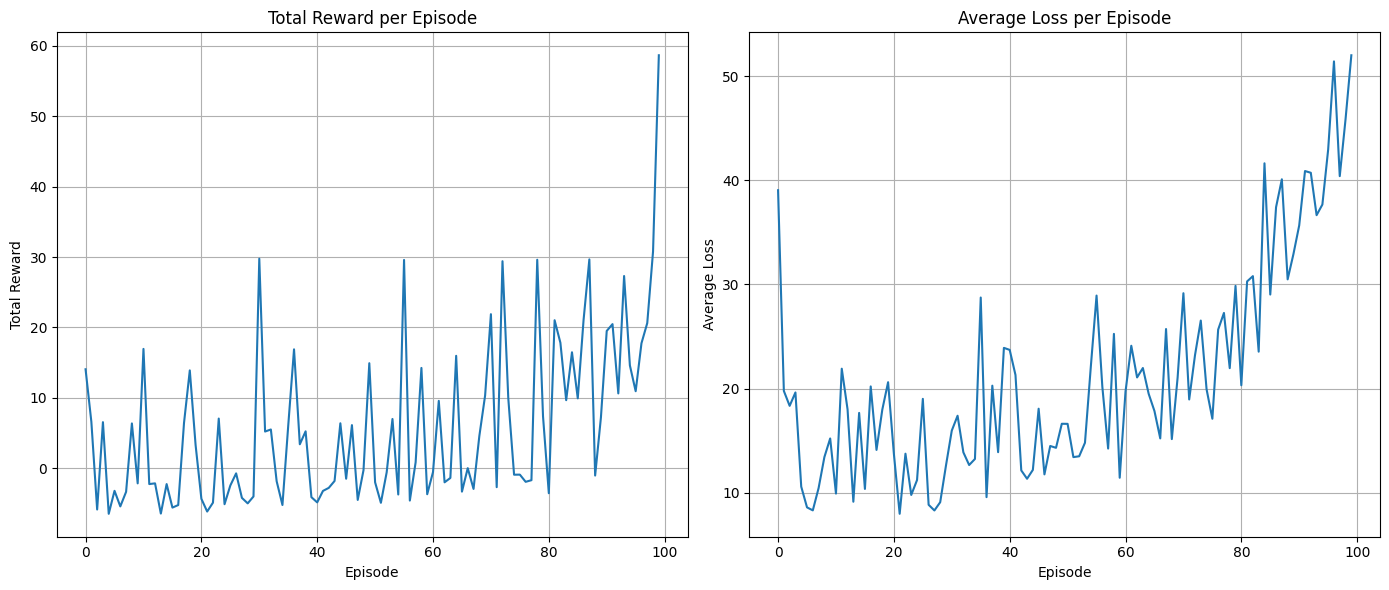


Training completed successfully.
Saving final model...
Final models saved.


In [50]:
import pygame
trainer = DQNTrainer(vec_env, num_envs=NUM_ENVS)

# Lists to store metrics for plotting
episode_rewards_history = []
episode_avg_loss_history = []

training_completed_successfully = False
print(f"Starting DQN training in {MAP_FILE} with {NUM_ENVS} envs, {NUM_AGENTS} agents and {N_PACKAGES} packages")
print(f"Running for {NUM_EPISODES} episodes.")

try:
    for episode_num in range(1, NUM_EPISODES + 1):
        # The exponential_epsilon function from in[16] expects 'steps_done'
        # Assuming 'steps_done' in that context refers to the number of episodes completed (0-indexed)
        current_epsilon = linear_epsilon(episode_num - 1) 
        
        episode_reward, avg_episode_loss = trainer.run_episode(current_epsilon)
        
        episode_rewards_history.append(episode_reward)
        episode_avg_loss_history.append(avg_episode_loss)
        
        if episode_num % 10 == 0 or episode_num == NUM_EPISODES: # Print every 10 episodes and the last one
            print(f"Episode {episode_num}/{NUM_EPISODES} | Reward: {episode_reward:.2f} | Avg Loss: {avg_episode_loss:.4f} | Epsilon: {current_epsilon:.3f}")

        # Optional: Periodic saving during training
        if episode_num % 50 == 0: # Example: Save every 50 episodes
            print(f"Saving checkpoint at episode {episode_num}...")
            save_model(trainer.agent_network, path=f"models/dqn_agent_ep{episode_num}.pt")
            
    training_completed_successfully = True

except KeyboardInterrupt:
    print("\nTraining interrupted by user (KeyboardInterrupt).")
    print("Saving current model state...")
    save_model(trainer.agent_network, path="models/dqn_agent_interrupted.pt")
    print("Models saved to _interrupted.pt files.")
except Exception as e:
    print(f"\nAn error occurred during training: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback for the exception
    print("Saving model due to exception...")
    save_model(trainer.agent_network, path="models/dqn_agent_exception.pt")
    print("Models saved to _exception.pt files.")
finally:
    # pygame.quit()
    print("\nTraining loop finished or was interrupted.")
    
    # Plotting the results
    if episode_rewards_history: # Check if there's any data to plot
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(episode_rewards_history)
        plt.title('Total Reward per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(episode_avg_loss_history)
        plt.title('Average Loss per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Average Loss')  
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("No data recorded for plotting.")

if training_completed_successfully:
    print("\nTraining completed successfully.")
    print("Saving final model...")
    save_model(trainer.agent_network, path="models/dqn_agent_final.pt")
    print("Final models saved.")